In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import joblib
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

2024-03-18 19:41:20.768948: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 19:41:22.395174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 19:41:29.502005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
columns_to_drop = ['customer','merchant', 'ind_recommended', 'activation', 'label']
categorical_features = ['merchant_profile_01'] 
numeric_features =['customer_spend_06',
 'customer_digital_activity_16',
 'distance_05',
 'customer_digital_activity_19',
 'customer_industry_spend_03',
 'customer_digital_activity_20',
 'customer_spend_03',
 'merchant_spend_07',
 'customer_spend_18',
 'merchant_spend_03',
 'distance_02',
 'customer_profile_04',
 'customer_digital_activity_14',
 'customer_digital_activity_10',
 'customer_profile_02',
 'customer_spend_01',
 'customer_digital_activity_01',
 'merchant_spend_02',
 'distance_03',
 'customer_digital_activity_03',
 'merchant_spend_11',
 'customer_spend_02',
 'merchant_spend_01',
 'customer_digital_activity_21',
 'customer_merchant_03',
 'customer_spend_19',
 'distance_01',
 'customer_digital_activity_12',
 'customer_profile_01',
 'customer_digital_activity_13',
 'customer_spend_05',
 'customer_spend_16',
 'customer_spend_13',
 'merchant_profile_03',
 'merchant_spend_05',
 'customer_digital_activity_02',
 'customer_spend_17',
 'customer_digital_activity_06',
 'customer_digital_activity_15',
 'customer_spend_15',
 'merchant_spend_10',
 'distance_04',
 'merchant_spend_04',
 'customer_industry_spend_04',
 'customer_industry_spend_01',
 'merchant_profile_02',
 'customer_profile_03',
 'customer_digital_activity_17',
 'customer_digital_activity_11',
 'merchant_spend_09',
 'merchant_spend_08',
 'customer_industry_spend_02',
 'customer_spend_07',
 'customer_spend_14',
 'customer_digital_activity_05',
 'customer_spend_04',
 'customer_digital_activity_04',
 'merchant_spend_06',
 'customer_digital_activity_22',
 'customer_industry_spend_05']
X_cols = ['merchant_profile_01',
 'customer_spend_06',
 'customer_digital_activity_16',
 'distance_05',
 'customer_digital_activity_19',
 'customer_industry_spend_03',
 'customer_digital_activity_20',
 'customer_spend_03',
 'merchant_spend_07',
 'customer_spend_18',
 'merchant_spend_03',
 'distance_02',
 'customer_profile_04',
 'customer_digital_activity_14',
 'customer_digital_activity_10',
 'customer_profile_02',
 'customer_spend_01',
 'customer_digital_activity_01',
 'merchant_spend_02',
 'distance_03',
 'customer_digital_activity_03',
 'merchant_spend_11',
 'customer_spend_02',
 'merchant_spend_01',
 'customer_digital_activity_21',
 'customer_merchant_03',
 'customer_spend_19',
 'distance_01',
 'customer_digital_activity_12',
 'customer_profile_01',
 'customer_digital_activity_13',
 'customer_spend_05',
 'customer_spend_16',
 'customer_spend_13',
 'merchant_profile_03',
 'merchant_spend_05',
 'customer_digital_activity_02',
 'customer_spend_17',
 'customer_digital_activity_06',
 'customer_digital_activity_15',
 'customer_spend_15',
 'merchant_spend_10',
 'distance_04',
 'merchant_spend_04',
 'customer_industry_spend_04',
 'customer_industry_spend_01',
 'merchant_profile_02',
 'customer_profile_03',
 'customer_digital_activity_17',
 'customer_digital_activity_11',
 'merchant_spend_09',
 'merchant_spend_08',
 'customer_industry_spend_02',
 'customer_spend_07',
 'customer_spend_14',
 'customer_digital_activity_05',
 'customer_spend_04',
 'customer_digital_activity_04',
 'merchant_spend_06',
 'customer_digital_activity_22',
 'customer_industry_spend_05']

In [3]:
# TO ADD imputed data
df = pd.read_parquet('train_test/imputed_train.parquet', engine='pyarrow')


In [4]:
# label y
# df['label'] =( (df['ind_recommended'] == 1) & (df['activation'] == 1)) | ( (df['ind_recommended'] == 0) & (df['activation'] == 0))
df['label'] =~( (df['ind_recommended'] == 1) & (df['activation'] == 1)) 

# Convert boolean values to integers (1 for True, 0 for False)
df['label'] =df['label'].astype(bool)

In [5]:
df['label'].value_counts()

label
True     12220135
False        9843
Name: count, dtype: int64

In [17]:
def prepare_dataset(df, columns_to_drop, test_size,random_state):
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['label'])
    
    # scale the training inputs
    x_train = df_train[X_cols]
    y_train = df_train['label'].to_numpy()
    
    # Define preprocessing steps for numeric features
    numeric_transformer = StandardScaler()
    # Define preprocessing steps for categorical features (using TargetEncoder)
    categorical_transformer = TargetEncoder()
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    x_train_scaled = preprocessor.fit_transform(x_train, y_train)
    preprocessor_save_path = 'scaler_model/model3_preprocessor1.joblib'
    joblib.dump(preprocessor, preprocessor_save_path)
    
    #scale and prepare testing data
    x_test = df_test[X_cols]
    x_test_scaled = preprocessor.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test, preprocessor

In [18]:
X_train, y_train, X_test, y_test,preprocessor = prepare_dataset(df, columns_to_drop, test_size=0.25, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9172483, 61) (9172483,)
(3057495, 61) (3057495,)


In [19]:
# Separate the normal transactions from the abnormal transactions.
normal_train_data = X_train[y_train]
normal_test_data = X_test[y_test]

anomalous_train_data = X_train[~y_train]
anomalous_test_data = X_test[~y_test]

In [20]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['customer_spend_06',
                                  'customer_digital_activity_16', 'distance_05',
                                  'customer_digital_activity_19',
                                  'customer_industry_spend_03',
                                  'customer_digital_activity_20',
                                  'customer_spend_03', 'merchant_spend_07',
                                  'customer_spend_18', 'merchant_spend_03',
                                  'distance_02', 'customer_profile_04',
                                  'customer_digital_act...
                                  'merchant_spend_02', 'distance_03',
                                  'customer_digital_activity_03',
                                  'merchant_spend_11', 'customer_spend_02',
                                  'merchant_spend_01',
                                  'customer_digital_activity_21',
                                  'customer_merchant_03', 'customer_spend_19',
                                  'distance_01', 'customer_digital_activity_12',
                                  'customer_profile_01',
                                  'customer_digital_activity_13', ...]),
                                ('cat', TargetEncoder(),
                                 ['merchant_profile_01'])])

In [10]:
# Save the StandardScaler
#joblib.dump(preprocessor, 'preprocessor_autoencoder.pkl')


['preprocessor_autoencoder.pkl']

In [11]:
# hyperparameters
batch_size = 32
num_classes =2
no_epochs  = 10


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def compile_and_fit(model, name, max_epochs):
    '''
    Description: Function to compile and fit model
    Parameters : Model Architecture, Model name, number of epochs
    Return     : model training history records
    '''
    #model.compile(optimizer='adam', loss='mae')    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # ModelCheckpoint callback
    checkpoint_cb = ModelCheckpoint(filepath=name + '.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

    history = model.fit(normal_train_data, normal_train_data, 
                        epochs=max_epochs, 
                        batch_size = batch_size,                        
                        validation_data=(normal_test_data,normal_test_data),
                        shuffle=True, 
                        callbacks=[early_stopping, checkpoint_cb])
    
    return history


In [ ]:
from tensorflow.keras.models import load_model

# Assuming you're resuming training
model_name = 'autoencoder_model1.weights'  # Use the same name you used for saving
max_epochs = 70  # Define how many more epochs you want to train

# Load the previously trained model
#model = load_model('autoencoder_model.weights.h5')

model =AnomalyDetector()
model.compile(optimizer='adam', loss='mae')   
model.load_weights('autoencoder_model1.weights.h5')
# Now, continue training the model from where it left off
history = compile_and_fit(model, model_name, max_epochs)

/home/FYP/poon0064/.conda/envs/RunJupyter/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Epoch 1/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 409s 1ms/step - loss: 0.4116 - val_loss: 0.4009
Epoch 2/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 393s 1ms/step - loss: 0.4003 - val_loss: 0.3974
Epoch 3/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 416s 1ms/step - loss: 0.3971 - val_loss: 0.3970
Epoch 4/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 439s 1ms/step - loss: 0.3955 - val_loss: 0.3942
Epoch 5/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 402s 1ms/step - loss: 0.3932 - val_loss: 0.3931
Epoch 6/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 444s 1ms/step - loss: 0.3925 - val_loss: 0.3925
Epoch 7/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 454s 1ms/step - loss: 0.3921 - val_loss: 0.3918
Epoch 8/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 419s 1ms/step - loss: 0.3920 - val_loss: 0.3917
Epoch 9/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 405s 1ms/step - loss: 0.3917 - val_loss: 0.3918
Epoch 10/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 400s 1ms/step - loss: 0.3917 - val_loss: 0.3916
Epoch 11/70
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 464s 2ms/ste

In [13]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([  
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(32, activation="relu"),
      layers.Dense(61, activation="sigmoid"),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [13]:
def compile_and_fit(model, name, max_epochs):
    '''
    Description: Function to compile and fit model
    Parameters : Model Architecture, Model name, number of epochs
    Return     : model traning history records
    '''
    model.compile(optimizer='adam', loss='mae')    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(normal_train_data, normal_train_data, 
                        epochs=max_epochs, 
                        batch_size = batch_size,                        
                        validation_data=(normal_test_data,normal_test_data),shuffle=True, callbacks=[early_stopping])
    
    return history

In [16]:

# model =AnomalyDetector()
# # Start training
# history = compile_and_fit(model, 'model',no_epochs)



2024-03-18 14:24:47.222622: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 328s 1ms/step - loss: 0.4167 - val_loss: 0.4073
Epoch 2/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 389s 1ms/step - loss: 0.4062 - val_loss: 0.4039
Epoch 3/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 353s 1ms/step - loss: 0.4040 - val_loss: 0.4032
Epoch 4/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 359s 1ms/step - loss: 0.4033 - val_loss: 0.4030
Epoch 5/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 332s 1ms/step - loss: 0.4029 - val_loss: 0.4027
Epoch 6/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 386s 1ms/step - loss: 0.4028 - val_loss: 0.4033
Epoch 7/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 332s 1ms/step - loss: 0.4028 - val_loss: 0.4026
Epoch 8/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 383s 1ms/step - loss: 0.4027 - val_loss: 0.4025
Epoch 9/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 351s 1ms/step - loss: 0.4027 - val_loss: 0.4025
Epoch 10/10
286410/286410 ━━━━━━━━━━━━━━━━━━━━ 351s 1ms/step - loss: 0.4027 - val_loss: 0.4032


In [17]:
model.save_weights('autoencoder_model.weights.h5')

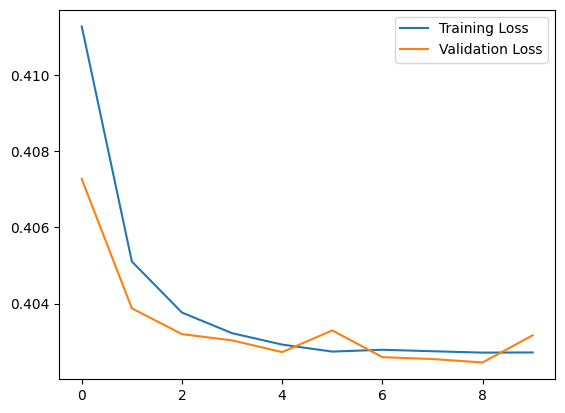

In [18]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [19]:
# Plot the reconstruction error on normal transactions from the training set
reconstructions = model.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

286410/286410 ━━━━━━━━━━━━━━━━━━━━ 204s 712us/step


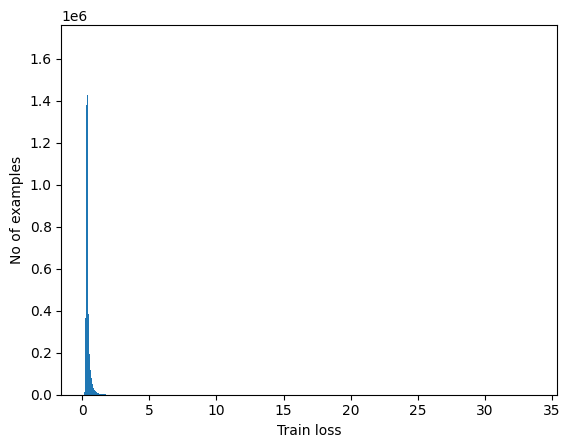

In [20]:
plt.hist(train_loss[None,:], bins=1000)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [21]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.5956222497259291


In [22]:
len(normal_train_data)

9165120

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


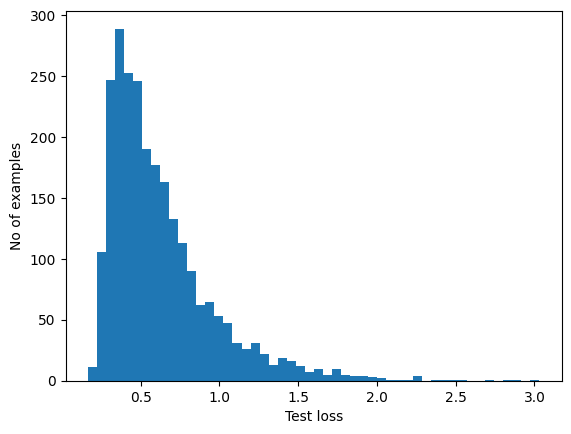

In [23]:
# Plot the reconstruction error on normal transactions from the testing set
reconstructions = model.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [26]:
preds = predict(model, X_test, threshold)
print_stats(preds, test_labels)

TypeError: predict() takes 2 positional arguments but 3 were given

In [25]:
def predict(model, data):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  # scaler = preprocessing.MinMaxScaler()
  # normalized_errors = scaler.fit_transform(loss.reshape(-1, 1))
  # params = beta.fit(normalized_errors)
  # probabilities = beta.pdf(normalized_errors, *params)
  return loss

In [28]:
eval_df = pd.read_parquet('train_test/imputed_test.parquet')

In [30]:
# eval_df= eval_df.fillna(0)
# TO FILL NA

In [34]:
# Load the saved StandardScaler
preprocessor = joblib.load('scaler_model/model3_preprocessor1.joblib')

In [35]:
# Scale the remaining features using the same scaler used during training
x_new_scaled = preprocessor.transform(eval_df[X_cols])



In [36]:
len(x_new_scaled)

12604600

In [59]:
# Load the saved model
model =AnomalyDetector()
model.compile(optimizer='adam', loss='mae')   
model.load_weights('autoencoder_model.weights.h5')

In [39]:

# # Determine the number of splits based on the desired size of each array
# split_size = 10000  # Adjust this value based on your dataset size and available memory
# num_splits = len(x_new_scaled) // split_size + 1

# # Split the large array into smaller arrays
# small_arrays = np.array_split(x_new_scaled, num_splits)

# # Perform inference on each small array and store the results
# inference_results = []
# for small_array in small_arrays:
#     # Perform inference on small_array using your model
#     # Replace the following line with your actual inference code
#     # Make predictions using the model
predictions = predict(model, x_new_scaled)
    #inference_results.append(predictions)

# Concatenate the inference results into a single array
#final_results = np.concatenate(inference_results)

# Output or further process the final_results array
print(len(predictions))


12604600


In [41]:
type(predictions)

tensorflow.python.framework.ops.EagerTensor

In [44]:
predictions = predictions.numpy()

In [45]:
from scipy.stats import beta
where_are_NaNs = np.isnan(predictions)
predictions[where_are_NaNs] = 0
scaler = preprocessing.MinMaxScaler()
normalized_errors = scaler.fit_transform(predictions.reshape(-1, 1))
params = beta.fit(normalized_errors)
probabilities = beta.pdf(normalized_errors, *params)

/home/FYP/poon0064/.conda/envs/RunJupyter/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [48]:
original_test_df = pd.read_csv('evaluation.csv')
customer_merchant_info = original_test_df[['customer', 'merchant']]

In [53]:
# Create a new DataFrame with columns A, B, and predictions
result_df = pd.concat([original_test_df[['customer','merchant']], pd.DataFrame(probabilities, columns=['predicted_score'])], axis=1)

In [54]:
result_df[['customer', 'merchant', 'predicted_score']].to_csv('submission/final_submission2.csv', index=False)

In [43]:
len(eval_df)

12604600

In [44]:
result_df[ 'predicted_score'].unique()

array([2.39701993e+018, 1.53164710e-062, 1.22553778e-063, ...,
       1.05469043e-079, 1.00804573e-082, 8.70679468e-105])

In [21]:
result_df = result_df.fillna(0)

In [23]:
result_df

,customer,merchant,predicted_score
0,467915,599167,0.0
1,467915,686617,0.0
2,467915,829193,0.0
3,467915,1077034,0.0
4,467915,876647,0.0
...,...,...,...
12604595,581658,1685038,0.0
12604596,559729,1741912,0.0
12604597,594817,1414695,0.0
12604598,597078,1414861,0.0
